In [ ]:
import sys
print(sys.version)

!pip install pingouin

In [2]:
#@title All important imports

# ignore future warnings for now
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
#from google.colab import files
from scipy import stats
import pingouin as pg
from pingouin import mixed_anova
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tabulate import tabulate

In [3]:
#@title Get the data from GitHub

# ignore git LFS files (to large to handle here)
!git config --global filter.lfs.smudge "git-lfs smudge --skip -- %f"
!git config --global filter.lfs.process "git-lfs filter-process --skip"
!git clone https://github.com/ukuhl/GenGapCHIRA2024 GenGapCHIRA2024_ressources

# read data file
df = pd.read_excel('GenGapCHIRA2024_ressources/GenGap_studyData/GenGap_surveyData.xlsx')

Klone nach 'GenGapCHIRA2024_ressources' ...
remote: Enumerating objects: 274, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 274 (delta 27), reused 247 (delta 12), pack-reused 0 (from 0)
Empfange Objekte: 100% (274/274), 17.78 MiB | 1.48 MiB/s, Fertig.
Löse Unterschiede auf: 100% (27/27), Fertig.


# Data cleaning

In [4]:
# Berechne den mean und standard deviation der interviewtime Spalte
mean_interviewtime = df['interviewtime'].mean()
std_interviewtime = df['interviewtime'].std()

# Berechne das Intervall
lower_bound = round(mean_interviewtime - 3 * std_interviewtime, 3)
upper_bound = round(mean_interviewtime + 3 * std_interviewtime, 3)

print(lower_bound, upper_bound)

minutes = int(mean_interviewtime // 60)
seconds = int(mean_interviewtime % 60)
formatted_time = f"{minutes}:{seconds:02d}"
print(f"Mean value in minutes:seconds: {formatted_time}")

-304.393 1455.938
Mean value in minutes:seconds: 9:35


In [5]:
# Overview of demographics, before cleaning: make an overview of median age and gender distribution per group
# Get unique entries for "Geschlecht" (gender)
unique_geschlecht = df['Geschlecht'].unique()
# Get unique entries for "Alter" (age)
unique_alter = df['Alter'].unique()

print("Unique entries for gender:", unique_geschlecht)
print("Unique entries for age:", unique_alter)

# Define the age groups
young = df[df['Alter'].isin(['20-29 Jahre alt', '30-39 Jahre alt'])]
old = df[df['Alter'].isin(['50-59 Jahre alt', '60-69 Jahre alt'])]

# Calculate the gender distribution in each age group
gender_distribution_young = young['Geschlecht'].value_counts(normalize=False)
gender_distribution_old = old['Geschlecht'].value_counts(normalize=False)

print("Gender distribution for people younger than 45 years:")
print(gender_distribution_young)

print("\nGender distribution for people older than 45 years:")
print(gender_distribution_old)

## make old / young groups
print(df['Alter'].dtype)
age_mapping = {
    '20-29 Jahre alt': 'young',
    '30-39 Jahre alt': 'young',
    '50-59 Jahre alt': 'old',
    '60-69 Jahre alt': 'old'
}
df['Alter_Gruppe']=df['Alter'].map(age_mapping).astype('category')

## get median age band:
# Sort the DataFrame by age band in a custom order
df['Alter'] = pd.Categorical(df['Alter'], categories=[
    '20-29 Jahre alt', '30-39 Jahre alt',
    '50-59 Jahre alt', '60-69 Jahre alt'
], ordered=True)

# Filter the DataFrame for younger and older groups
younger_than_45 = df[df['Alter'].isin(['20-29 Jahre alt', '30-39 Jahre alt'])]
older_than_45 = df[df['Alter'].isin(['50-59 Jahre alt', '60-69 Jahre alt'])]

# Calculate the median age band for each group
median_age_band_younger = younger_than_45['Alter'].sort_values().iloc[len(younger_than_45) // 2]
median_age_band_older = older_than_45['Alter'].sort_values().iloc[len(older_than_45) // 2]

print(f"Median age band for people younger than 45 years: {median_age_band_younger}")
print(f"Median age band for people older than 45 years: {median_age_band_older}")


Unique entries for gender: ['weiblich' 'männlich' 'nicht-binär/ genderqueer']
Unique entries for age: ['50-59 Jahre alt' '30-39 Jahre alt' '20-29 Jahre alt' '60-69 Jahre alt']
Gender distribution for people younger than 45 years:
Geschlecht
weiblich                    30
männlich                    29
nicht-binär/ genderqueer     1
Name: count, dtype: int64

Gender distribution for people older than 45 years:
Geschlecht
weiblich    31
männlich    29
Name: count, dtype: int64
object
Median age band for people younger than 45 years: 20-29 Jahre alt
Median age band for people older than 45 years: 50-59 Jahre alt


In [6]:
#@title Check for singificant differences in age BEFORE cleaning

# Create a contingency table
contingency_table = pd.crosstab(df['Geschlecht'], df['Alter_Gruppe'])

# Perform the Chi-Square test for independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpretation
if p < 0.05:
    print("There is a significant difference in gender distribution between the age groups.")
else:
    print("There is no significant difference in gender distribution between the age groups.")

Chi-Square Statistic: 1.0163934426229506
P-Value: 0.6015794166292067
There is no significant difference in gender distribution between the age groups.


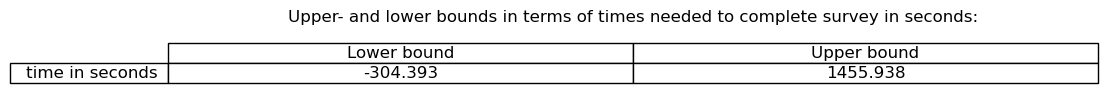

In [7]:
# Data
data = {
    'Lower bound': [lower_bound],
    'Upper bound': [upper_bound]
}

# generate dataframe
df_grenzen = pd.DataFrame(data)

# plot table
fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_grenzen.values, colLabels=df_grenzen.columns, rowLabels=['time in seconds'], cellLoc='center', loc='center')

# Index entfernen
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Tabelle anzeigen
plt.title('Upper- and lower bounds in terms of times needed to complete survey in seconds:', pad=-10)
plt.show()

According to the empirical 68-95-99.7 rule, 99.7% of our valid data points fall within three times the standard deviation. Based on this, no one would be excluded on the lower end. On the upper end, only two data points could be excluded, but it was decided not to do so in order to avoid penalizing careful observation or breaks.

In [8]:
# determine cases where participants classified the validation image as real (="echt")
valid_df = df[df['Valid'] == 'echt']
print(valid_df['id'].count())

8


In 8 cases, the validation image was not correctly identified. This image was deliberately recognizable as distorted and artificial, so it should not have been marked as real by anyone seriously participating in the survey. These 8 responses will be excluded, as the answers and the seriousness of these participants cannot be trusted.

In [9]:
# remove cases where participants classified the validation image as real (="echt")
df_cleaned = df[df['Valid'] != 'echt']

In [10]:
# check final sample size
len(df_cleaned)

112

After excluding invalid responses, **112** participants remain.

In [11]:
# Overview of demographics, after cleaning: make an overview of median age and gender distribution per group
# Get unique entries for "Geschlecht"
unique_geschlecht = df_cleaned['Geschlecht'].unique()
# Get unique entries for "Alter"
unique_alter = df_cleaned['Alter'].unique()

print("Unique entries for Geschlecht:", unique_geschlecht)
print("Unique entries for Alter:", unique_alter)

# Define the age groups
young = df_cleaned[df_cleaned['Alter'].isin(['20-29 Jahre alt', '30-39 Jahre alt'])]
old = df_cleaned[df_cleaned['Alter'].isin(['50-59 Jahre alt', '60-69 Jahre alt'])]

# Calculate the gender distribution in each age group
gender_distribution_young = young['Geschlecht'].value_counts(normalize=False)
gender_distribution_old = old['Geschlecht'].value_counts(normalize=False)

print("Gender distribution for people younger than 45 years:")
print(gender_distribution_young)

print("\nGender distribution for people older than 45 years:")
print(gender_distribution_old)

Unique entries for Geschlecht: ['weiblich' 'männlich' 'nicht-binär/ genderqueer']
Unique entries for Alter: ['50-59 Jahre alt', '30-39 Jahre alt', '20-29 Jahre alt', '60-69 Jahre alt']
Categories (4, object): ['20-29 Jahre alt' < '30-39 Jahre alt' < '50-59 Jahre alt' < '60-69 Jahre alt']
Gender distribution for people younger than 45 years:
Geschlecht
männlich                    28
weiblich                    28
nicht-binär/ genderqueer     1
Name: count, dtype: int64

Gender distribution for people older than 45 years:
Geschlecht
weiblich    29
männlich    26
Name: count, dtype: int64


In [12]:
## get median age band:
# Sort the DataFrame by age band in a custom order
df_cleaned.loc[:, 'Alter'] = pd.Categorical(df_cleaned['Alter'], categories=[
    '20-29 Jahre alt', '30-39 Jahre alt', '40-49 Jahre alt',
    '50-59 Jahre alt', '60-69 Jahre alt'
], ordered=True)

# Filter the DataFrame for younger and older groups
younger_than_45 = df_cleaned[df_cleaned['Alter'].isin(['20-29 Jahre alt', '30-39 Jahre alt'])]
older_than_45 = df_cleaned[df_cleaned['Alter'].isin(['50-59 Jahre alt', '60-69 Jahre alt'])]

# Calculate the median age band for each group
median_age_band_younger = younger_than_45['Alter'].sort_values().iloc[len(younger_than_45) // 2]
median_age_band_older = older_than_45['Alter'].sort_values().iloc[len(older_than_45) // 2]

print(f"Median age band for people younger than 45 years: {median_age_band_younger}")
print(f"Median age band for people older than 45 years: {median_age_band_older}")

Median age band for people younger than 45 years: 20-29 Jahre alt
Median age band for people older than 45 years: 50-59 Jahre alt


In [13]:
#@title Check for singificant differences in age AFTER cleaning

# Create a contingency table
contingency_table = pd.crosstab(df_cleaned['Geschlecht'], df_cleaned['Alter_Gruppe'])

# Perform the Chi-Square test for independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpretation
if p < 0.05:
    print("There is a significant difference in gender distribution between the age groups.")
else:
    print("There is no significant difference in gender distribution between the age groups.")

Chi-Square Statistic: 1.056240459379887
P-Value: 0.5897124524051718
There is no significant difference in gender distribution between the age groups.


In [14]:
#@title Functions to generate columns

# columns to be checked
echt_columns = [f'Echt{i}' for i in range(1, 31)]
fake_columns = [f'Fake{i}' for i in range(1, 31)]

# function to mark the correctly classified responses
def mark_correct_answers(row):
    new_row = {}
    for col in echt_columns:
        if col in row:
            new_row[f'{col}_correct'] = row[col] == 'echt'
    for col in fake_columns:
        if col in row:
            new_row[f'{col}_correct'] = row[col] == 'künstlich generiert'
    return pd.Series(new_row)


# function to compute the percentage or errors
def calculate_false_percentages(row):
    correct_columns = [col for col in df_cleaned.columns if col.endswith('_correct')]
    echt_correct_columns = [col for col in correct_columns if col.startswith('Echt')]
    fake_correct_columns = [col for col in correct_columns if col.startswith('Fake')]

    # compute overall error percentage
    total = len(correct_columns)
    false_count = sum(row[col] == False for col in correct_columns)
    overall_false_percentage = (false_count / total) * 100 if total > 0 else 0

    # compute error percentage for real images
    total_echt = len(echt_correct_columns)
    false_count_echt = sum(row[col] == False for col in echt_correct_columns)
    echt_false_percentage = (false_count_echt / 30) * 100 if total > 0 else 0

    # compute error percentage for artificial images
    total_fake = len(fake_correct_columns)
    false_count_fake = sum(row[col] == False for col in fake_correct_columns)
    fake_false_percentage = (false_count_fake / 30) * 100 if total > 0 else 0

    return pd.Series({
        'False_percentage': overall_false_percentage,
        'Echt_false_percentage': echt_false_percentage,
        'Fake_false_percentage': fake_false_percentage
    })


# function for excel specific adaptation of columns
def adjust_column_widths(filename):
    workbook = load_workbook(filename)
    sheet = workbook.active
    for column in sheet.columns:
        max_length = 0
        column_letter = get_column_letter(column[0].column)
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(cell.value)
            except:
                pass
        adjusted_width = (max_length + 2)
        sheet.column_dimensions[column_letter].width = adjusted_width
    workbook.save(filename)

# function to count wrongly classified real images
def count_false_echt(row):
    echt_correct_columns = [col for col in df_cleaned.columns if col.startswith('Echt') and col.endswith('_correct')]
    return sum(row[col] == False for col in echt_correct_columns)

# function to count wrongly classified artificial images
def count_false_fake(row):
    fake_correct_columns = [col for col in df_cleaned.columns if col.startswith('Fake') and col.endswith('_correct')]
    return sum(row[col] == False for col in fake_correct_columns)

# function to classify age groups
def add_age_group_column(df, age_column='Alter'):
    conditions = [
        (df[age_column] == '50-59 Jahre alt') | (df[age_column] == '60-69 Jahre alt')
    ]
    choices = ['old']
    df['Age_Group'] = np.select(conditions, choices, default='young')
    return df

# function to map confidence to integer values
def map_confidence_to_int(confidence_level):
    mapping = {
        'sehr unsicher': 1,
        'unsicher': 2,
        'neutral': 3,
        'sicher': 4,
        'sehr sicher': 5
    }
    return mapping.get(confidence_level, 0)

# function to apply confidence mapping
def add_confidence_int_columns(df):
    df['ConEcht_Int'] = df['ConEcht'].apply(map_confidence_to_int)
    df['ConFake_Int'] = df['ConFake'].apply(map_confidence_to_int)
    return df

# list columns with times for real (echt_time) and artificial (fake_time) decisions
echt_time_columns = [col for col in df_cleaned.columns if col.startswith('Echt') and col.endswith('Time')]
fake_time_columns = [col for col in df_cleaned.columns if col.startswith('Fake') and col.endswith('Time')]
all_time_columns = ['AlterTime', 'ValidTime'] + echt_time_columns + fake_time_columns

In [15]:
#@title Apply dataframe operations

# mark columns as real orv artificial
correct_columns = df_cleaned.apply(mark_correct_answers, axis=1)
df_cleaned = pd.concat([df_cleaned, correct_columns], axis=1)

# compute error rates
false_percentages = df_cleaned.apply(calculate_false_percentages, axis=1)
df_cleaned = pd.concat([df_cleaned, false_percentages], axis=1)

# new columns counting false decisions
df_cleaned['False_count_echt'] = df_cleaned.apply(count_false_echt, axis=1)
df_cleaned['False_count_fake'] = df_cleaned.apply(count_false_fake, axis=1)

# compute average times
df_cleaned['Overall_avg_time'] = df_cleaned[all_time_columns].mean(axis=1)
df_cleaned['Echt_avg_time'] = df_cleaned[echt_time_columns].mean(axis=1)
df_cleaned['Fake_avg_time'] = df_cleaned[fake_time_columns].mean(axis=1)

# add column for age groups
df_cleaned = add_age_group_column(df_cleaned)

# add column for confidence as integer values
df_cleaned = add_confidence_int_columns(df_cleaned)

# Analysis and statistical evaluation

## Descriptive statistics

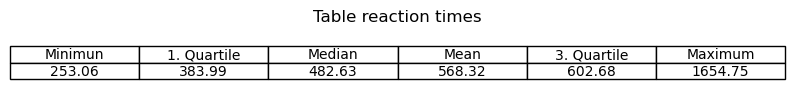

In [16]:
#@title Table reaction times

# compute statistics
stats_time = {
    'rounded overall survey time in seconds': [
        round(df_cleaned['interviewtime'].min(), 2),
        round(df_cleaned['interviewtime'].quantile(0.25), 2),
        round(df_cleaned['interviewtime'].median(), 2),
        round(df_cleaned['interviewtime'].mean(), 2),
        round(df_cleaned['interviewtime'].quantile(0.75), 2),
        round(df_cleaned['interviewtime'].max(), 2)
    ]
}

# generate DataFrame for stats
stats_df = pd.DataFrame(stats_time, index=['Minimun', '1. Quartile', 'Median', 'Mean', '3. Quartile', 'Maximum']).transpose()

# plot table
fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=stats_df.values, colLabels=stats_df.columns, cellLoc='center', loc='center')
plt.title('Table reaction times', pad=-10)
plt.show()

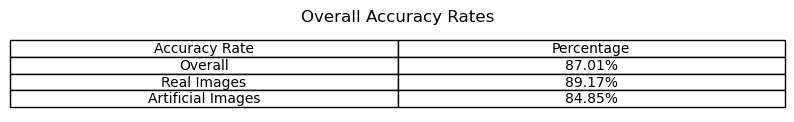

In [17]:
#@title Tabelle accuracy rates

# compute accuracy rates
accuracy_rates = {
    'Accuracy Rate': ['Overall', 'Real Images', 'Artificial Images'],
    'Percentage': [
        f"{100 - df_cleaned['False_percentage'].mean():.2f}%",
        f"{100 - df_cleaned['Echt_false_percentage'].mean():.2f}%",
        f"{100 - df_cleaned['Fake_false_percentage'].mean():.2f}%"
    ]
}

# generate DataFrame for accuracy rates
accuracy_df = pd.DataFrame(accuracy_rates)

# plot and show table
fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=accuracy_df.values, colLabels=accuracy_df.columns, cellLoc='center', loc='center')
plt.title('Overall Accuracy Rates', pad=10)
plt.show()

In [18]:
#@title One sample t-test on accuracy rates

# define data
observed_accuracy = round((100 - df_cleaned['False_percentage'].mean())/100,4)
n = 112  # number of participants after cleaning
null_hypothesis = 0.5  # 50% chance rate

# Compute standard error
standard_error = np.sqrt((observed_accuracy * (1 - observed_accuracy)) / n)

# manually compute t-statistic
t_statistic = (observed_accuracy - null_hypothesis) / standard_error

# compute p-value
freedom = n - 1  # degrees of freedom
p_value = stats.t.sf(abs(t_statistic), freedom) * 2  # two-sided test

# Results:
print(f"Observed Accuracy: {observed_accuracy:.4f}")
print(f"Number of participants: {n}")
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Degrees of freedom: {freedom}")

# Interpretation
if p_value < 0.05:
    print("Overall accuracy is significantly different from chance behavior.")
else:
    print("Overall accuracy is not significantly different from chance behavior.")

Observed Accuracy: 0.8701
Number of participants: 112
t-statistic: 11.6503
p-value: 5.6497e-21
Degrees of freedom: 111
Overall accuracy is significantly different from chance behavior.


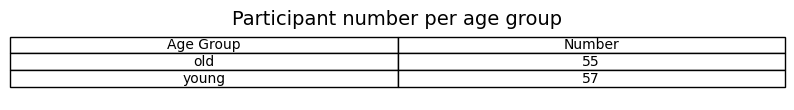

In [19]:
#@title Table showing participant numbers per age group

# compute numbers
age_distribution = df_cleaned['Age_Group'].value_counts().sort_index()

# generate dataframe
age_df = pd.DataFrame(age_distribution).reset_index()
age_df.columns = ['Age Group', 'Number']

# generate and plot table
fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=age_df.values, colLabels=age_df.columns, cellLoc='center', loc='center')

plt.text(0.5, 1.05, 'Participant number per age group', ha='center', va='center', transform=ax.transAxes, fontsize=14)

plt.show()

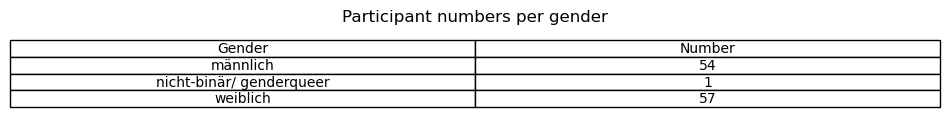

In [20]:
#@title Table showing participant numbers per gender ('Geschlecht')

# compute numbers
gender_distribution = df_cleaned['Geschlecht'].value_counts().sort_index()

# generate dataframe
gender_df = pd.DataFrame(gender_distribution).reset_index()
gender_df.columns = ['Gender', 'Number']

# generate and plot table
fig, ax = plt.subplots(figsize=(12, 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=gender_df.values, colLabels=gender_df.columns, cellLoc='center', loc='center')

# Überschrift für Geschlechter-Tabelle als Text hinzufügen
plt.title('Participant numbers per gender', pad=10)

# Tabelle anzeigen
plt.show()

## Inferential statistics

Analyze sphericity first - is sphericity given?
True


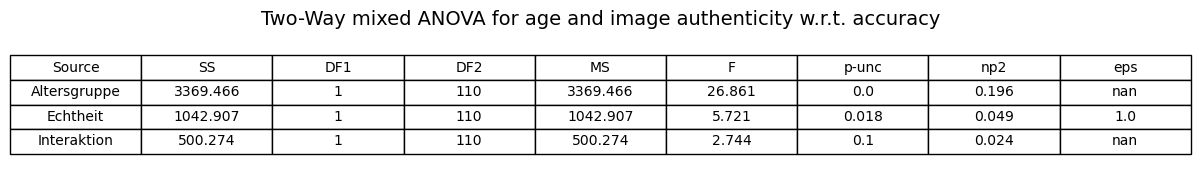

In [21]:
#@title Two Way mixed ANOVA with factors age and image authenticity ("Echtheit") on accuracy

dependent_vars_error = ['Echt_false_percentage',
'Fake_false_percentage','Age_Group']

filtered_df_error = df_cleaned[dependent_vars_error]

# avoid SettingWithCopyWarning:
filtered_df_error = filtered_df_error.copy()

# userId hinzufügen
filtered_df_error['userID'] = list(range(1, len(filtered_df_error) + 1))

# melt zu long format:
df_long_error = pd.melt(filtered_df_error, id_vars=['Age_Group','userID'], value_vars=['Echt_false_percentage', 'Fake_false_percentage'],
                  var_name='Echtheit', value_name='Percentage')

result_sphericity=pg.sphericity(data=df_long_error, dv='Percentage', within='Echtheit', subject='userID', method='mauchly', alpha=0.05)

print('Analyze sphericity first - is sphericity given?')
print(result_sphericity[0])

# ANOVA:
result_error = pg.mixed_anova(dv='Percentage', between='Age_Group',
                              within='Echtheit', subject='userID',
                              correction='auto', data=df_long_error)

# rounding results:
result_error_rounded = result_error.round(3)

# generate dataframe with stats:
new_data = {
    'Source': ['Altersgruppe', 'Echtheit', 'Interaktion'],
    'SS': result_error_rounded['SS'],
    'DF1': result_error_rounded['DF1'],
    'DF2': result_error_rounded['DF2'],
    'MS': result_error_rounded['MS'],
    'F': result_error_rounded['F'],
    'p-unc': result_error_rounded['p-unc'],
    'np2': result_error_rounded['np2'],
    'eps': result_error_rounded['eps']
}

new_result = pd.DataFrame(new_data)

# generate table:
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')

tbl = ax.table(cellText=new_result.values,
               colLabels=new_result.columns,
               cellLoc='center', loc='center')

plt.title('Two-Way mixed ANOVA for age and image authenticity w.r.t. accuracy', fontsize=14, pad=-10)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.5)

plt.tight_layout()
plt.show()

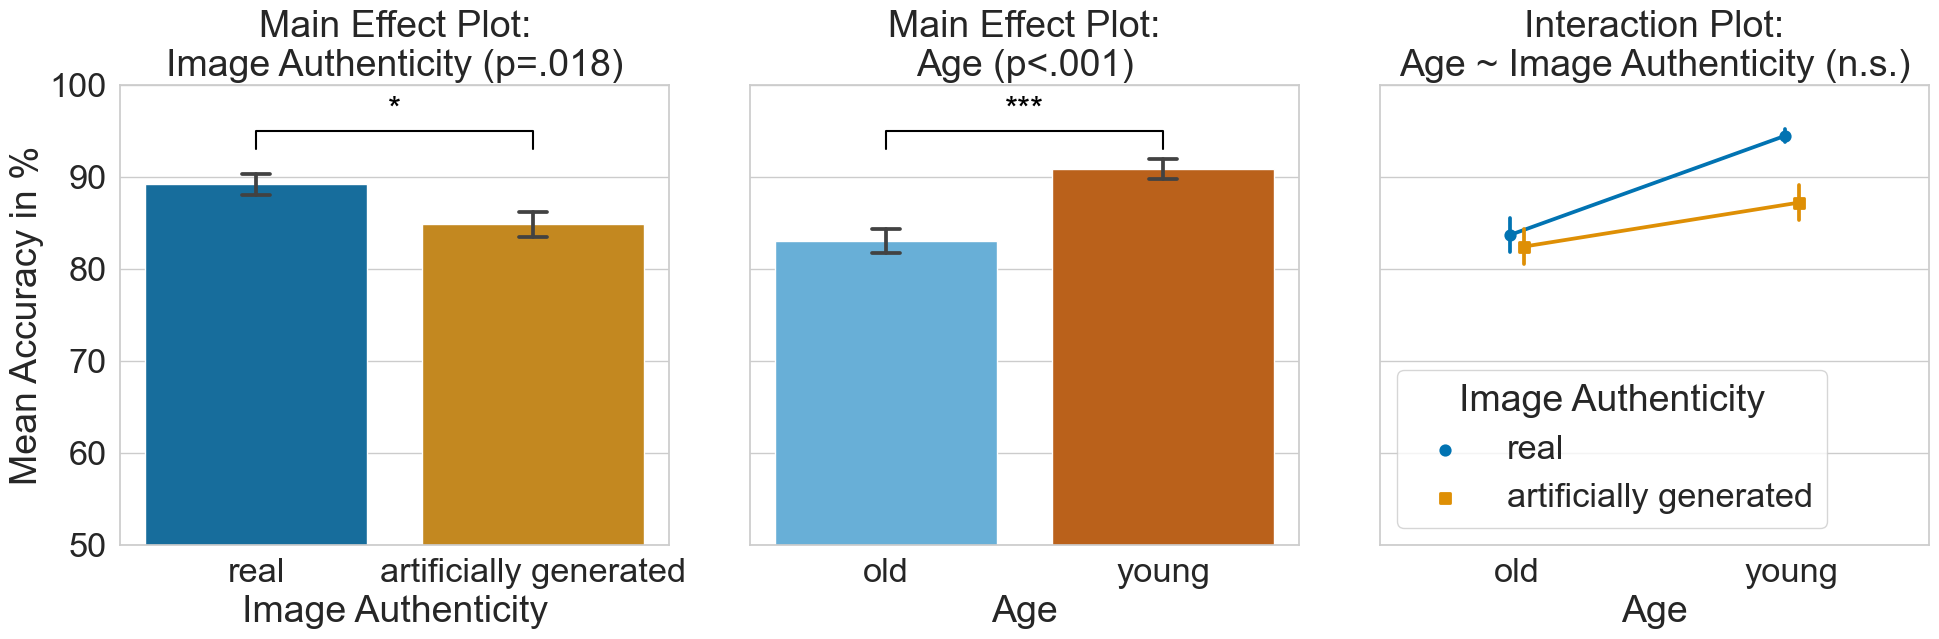

In [22]:
#### Generate plot showing main effects and interaction (Figure 4 in CHIRA24 paper)

df_long_accuracy=df_long_error
df_long_accuracy['MeanAccuracy']=100-df_long_error['Percentage']

# Replace the factor labels
df_long_accuracy['Echtheit'] = df_long_accuracy['Echtheit'].replace({
    'Echt_false_percentage': 'real',
    'Fake_false_percentage': 'artificially generated'
})

# Set the color palette
colors = sns.color_palette("colorblind")
age_palette = {'real': colors[0], 'artificially generated': colors[1], 'young':colors[3], 'old':colors[9]}

### plotting starts:
# Set global font size
sns.set_theme(style="whitegrid",font_scale=2.25)

# Create the figure and axes for three side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Main effects plot for 'Echtheit'
sns.barplot(
    data=df_long_accuracy, 
    x='Echtheit', 
    y='MeanAccuracy', 
    #ci='sem',  # Use standard error of the mean
    errorbar='se',
    palette=age_palette,  # Use default color palette
    capsize=.1,
    ax=axes[0]
)
axes[0].set_title('Main Effect Plot:\nImage Authenticity (p=.018)')
axes[0].set_xlabel('Image Authenticity')
axes[0].set_ylabel('Mean Accuracy in %')
axes[0].set_ylim(50, 100)  # Adjust y-axis to percentage scale

# Add significance annotation with bracket
x1, x2 = 0, 1  # x-coordinates of the bars
y, h, col = 93, 2, 'black'  # y: height, h: height of the bracket, col: color
axes[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)
axes[0].annotate('*', xy=((x1+x2)*.5, y+h), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', color=col, fontsize=24)

# Main effects plot for 'Age_Group'
sns.barplot(
    data=df_long_accuracy, 
    x='Age_Group', 
    y='MeanAccuracy', 
    #ci='sem',  # Use standard error of the mean
    errorbar='se',
    palette=age_palette,  # Apply colorblind palette to age groups
    capsize=.1,
    ax=axes[1]
)
axes[1].set_title('Main Effect Plot:\nAge (p<.001)')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('')
axes[1].set_ylim(50, 100)  # Keep y-axis consistent across plots

# Add significance annotation with bracket
x1, x2 = 0, 1  # x-coordinates of the bars
y, h, col = 93, 2, 'black'  # y: height, h: height of the bracket, col: color
axes[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)
axes[1].annotate('***', xy=((x1+x2)*.5, y+h), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', color=col, fontsize=24)

# Interaction plot showing mean accuracy per age group as a function of Echtheit
sns.pointplot(
    data=df_long_accuracy,
    x='Age_Group',
    y='MeanAccuracy',
    hue='Echtheit',
    palette=age_palette,  # Apply colorblind palette to age groups
    markers=['o', 's'],
    ax=axes[2],
    dodge=True,
    errorbar='se'
)
axes[2].set_title('Interaction Plot:\nAge ~ Image Authenticity (n.s.)')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('')  # Set an empty y-label
plt.legend(title='Image Authenticity')

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig('H2_Accuracy.pdf', dpi=300, bbox_inches='tight')
plt.savefig('H2_Accuracy.svg', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()


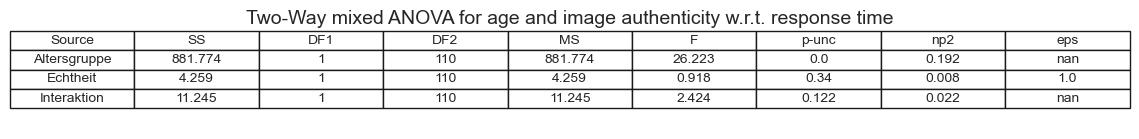

In [23]:
#@title Two Way mixed ANOVA with factors age and image authenticity ("Echtheit") on response time

dependent_vars_time = ['Echt_avg_time',
'Fake_avg_time','Age_Group']

filtered_df_time = df_cleaned[dependent_vars_time]

# avoid SettingWithCopyWarning:
filtered_df_time = filtered_df_time.copy()

# userId hinzufügen
filtered_df_time['userID'] = list(range(1, len(filtered_df_time) + 1))

# melt zu long format:
df_long_time = pd.melt(filtered_df_time, id_vars=['Age_Group','userID'], value_vars=['Echt_avg_time', 'Fake_avg_time'],
                  var_name='Echtheit', value_name='Sekunden')

# ANOVA:
result_error = pg.mixed_anova(dv='Sekunden', between='Age_Group',
                              within='Echtheit', subject='userID',
                              correction=True, data=df_long_time)

# rounding results:
result_error_rounded = result_error.round(3)

# dataframe with stats
new_data = {
    'Source': ['Altersgruppe', 'Echtheit', 'Interaktion'],
    'SS': result_error_rounded['SS'],
    'DF1': result_error_rounded['DF1'],
    'DF2': result_error_rounded['DF2'],
    'MS': result_error_rounded['MS'],
    'F': result_error_rounded['F'],
    'p-unc': result_error_rounded['p-unc'],
    'np2': result_error_rounded['np2'],
    'eps': result_error_rounded['eps']
}

new_result = pd.DataFrame(new_data)

# generate table
fig, ax = plt.subplots(figsize=(12, 2))
ax.axis('off')

tbl = ax.table(cellText=new_result.values,
               colLabels=new_result.columns,
               cellLoc='center', loc='center')

plt.title('Two-Way mixed ANOVA for age and image authenticity w.r.t. response time', fontsize=14, pad=-10)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.5)

plt.tight_layout()
plt.show()

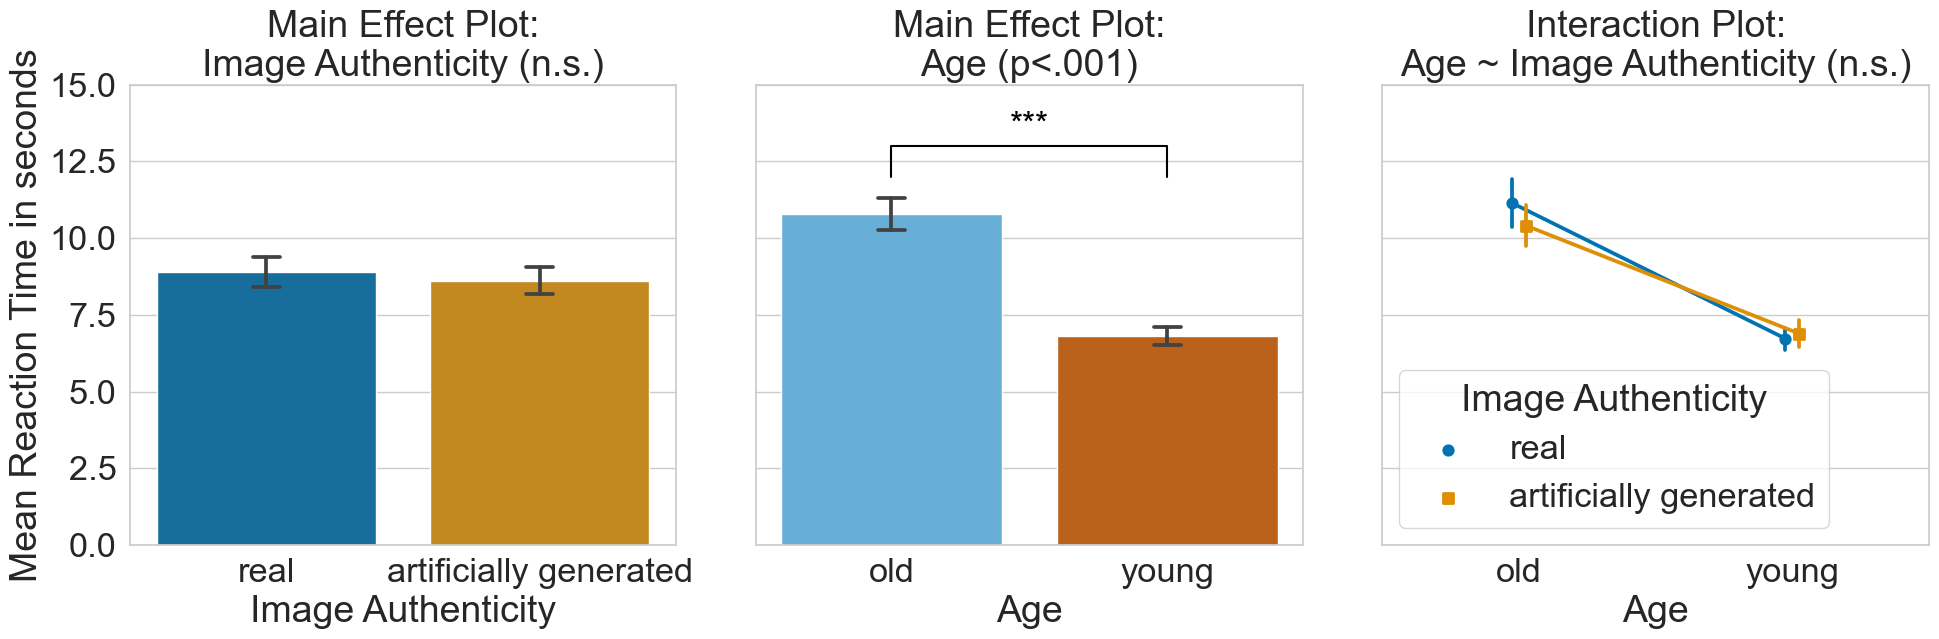

In [24]:
#### Generate plot showing main effects and interaction (Figure 7 in CHIRA24 paper)

df_long_time['Echtheit'] = df_long_time['Echtheit'].replace({
    'Echt_avg_time': 'real',
    'Fake_avg_time': 'artificially generated'
})

# Set the color palette
colors = sns.color_palette("colorblind")
age_palette = {'real': colors[0], 'artificially generated': colors[1], 'young':colors[3], 'old':colors[9]}

### plotting starts:
# Set global font size
sns.set_theme(style="whitegrid",font_scale=2.25)

# Create the figure and axes for three side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Main effects plot for image authenticity ('Echtheit')
sns.barplot(
    data=df_long_time, 
    x='Echtheit', 
    y='Sekunden', 
    #ci='sem',  # Use standard error of the mean
    errorbar='se',
    palette=age_palette,  # Use default color palette
    capsize=.1,
    ax=axes[0]
)
axes[0].set_title('Main Effect Plot:\nImage Authenticity (n.s.)')
axes[0].set_xlabel('Image Authenticity')
axes[0].set_ylabel('Mean Reaction Time in seconds')

# Main effects plot for 'Age_Group'
sns.barplot(
    data=df_long_time, 
    x='Age_Group', 
    y='Sekunden', 
    #ci='sem',  # Use standard error of the mean
    errorbar='se',
    palette=age_palette,  # Apply colorblind palette to age groups
    capsize=.1,
    ax=axes[1]
)
axes[1].set_title('Main Effect Plot:\nAge (p<.001)')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 15)  # Keep y-axis consistent across plots

# Add significance annotation with bracket
x1, x2 = 0, 1  # x-coordinates of the bars
y, h, col = 12, 1, 'black'  # y: height, h: height of the bracket, col: color
axes[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)
axes[1].annotate('***', xy=((x1+x2)*.5, y+h), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', color=col, fontsize=24)

# Interaction plot showing mean accuracy per age group as a function of Echtheit
sns.pointplot(
    data=df_long_time,
    x='Age_Group',
    y='Sekunden',
    hue='Echtheit',
    palette=age_palette,  # Apply colorblind palette to age groups
    markers=['o', 's'],
    ax=axes[2],
    dodge=True,
    errorbar='se'
)
axes[2].set_title('Interaction Plot:\nAge ~ Image Authenticity (n.s.)')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('')  # Set an empty y-label
plt.legend(title='Image Authenticity')

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig('H6_ReactionTime.pdf', dpi=300, bbox_inches='tight')
plt.savefig('H6_ReactionTime.svg', dpi=300, bbox_inches='tight')

# Show the plots
plt.show()

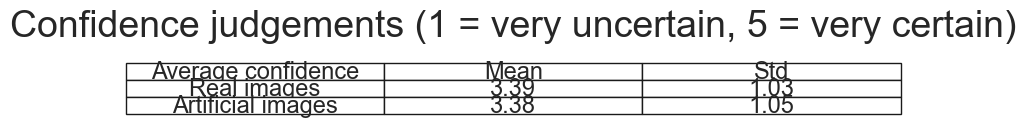

In [25]:
#@title Analysis of confidence values, Mann-Whitney U-Test

# compute mean and std for confidence per image type:
confidence_levels = {
    'Average confidence': ['Real images', 'Artificial images'],
    'Mean': [
        f"{df_cleaned['ConEcht_Int'].mean():.2f}",  
        f"{df_cleaned['ConFake_Int'].mean():.2f}"
    ],
    'Std': [
        f"{df_cleaned['ConEcht_Int'].std():.2f}",  
        f"{df_cleaned['ConFake_Int'].std():.2f}"
    ]
}

# generate dataframe for confidence
confidence_df = pd.DataFrame(confidence_levels)

# plot and show table
fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=confidence_df.values, colLabels=confidence_df.columns, cellLoc='center', loc='center')
plt.title('Confidence judgements (1 = very uncertain, 5 = very certain)', pad=10)
plt.show()

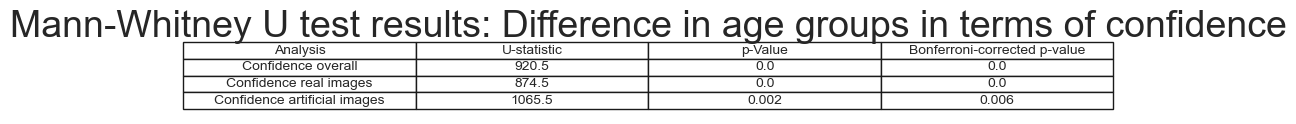

In [26]:
#@title Mann-Whitney U Statistics

# define age groups
age_group_old = df_cleaned[df_cleaned['Age_Group'] == 'old']
age_group_young = df_cleaned[df_cleaned['Age_Group'] == 'young']

overall_conf_old=pd.merge(age_group_old['ConEcht_Int'], age_group_old['ConFake_Int'], left_index=True, right_index=True)
overall_conf_young=pd.merge(age_group_young['ConEcht_Int'], age_group_young['ConFake_Int'], left_index=True, right_index=True)

# Mann-Whitney U Test: Confidence in recognizing images overall
u_statistic_overall, p_value_overall = mannwhitneyu(overall_conf_old.mean(axis=1),overall_conf_young.mean(axis=1))

# Mann-Whitney U Test: Confidence in recognizing real images as real
u_statistic_echt, p_value_echt = mannwhitneyu(age_group_old['ConEcht_Int'], age_group_young['ConEcht_Int'])

# Mann-Whitney U Test: Confidence in recognizing artificial images as artificial
u_statistic_fake, p_value_fake = mannwhitneyu(age_group_old['ConFake_Int'], age_group_young['ConFake_Int'])

# round values
u_statistic_overall = round(u_statistic_overall, 3)
u_statistic_echt = round(u_statistic_echt, 3)
u_statistic_fake = round(u_statistic_fake, 3)
p_value_overall = round(p_value_overall, 3)
p_value_echt = round(p_value_echt, 3)
p_value_fake = round(p_value_fake, 3)

# perform Bonferroni-Correction
num_tests = 3
bonferroni_alpha = 0.05 * num_tests

# Bonferroni-korrigierte p-Werte berechnen
corrected_p_value_overall = round(min(p_value_overall * num_tests, 1.0), 3)
corrected_p_value_echt = round(min(p_value_echt * num_tests, 1.0), 3)
corrected_p_value_fake = round(min(p_value_fake * num_tests, 1.0), 3)

# Ergebnisse in einem DataFrame darstellen
mann_whitney_results = {
    'Analysis': ['Confidence overall', 'Confidence real images', 'Confidence artificial images'],
    'U-statistic': [u_statistic_overall, u_statistic_echt, u_statistic_fake],
    'p-Value': [p_value_overall, p_value_echt, p_value_fake],
    'Bonferroni-corrected p-value': [corrected_p_value_overall, corrected_p_value_echt, corrected_p_value_fake]
}

mann_whitney_df = pd.DataFrame(mann_whitney_results)

# Tabelle plotten und anzeigen
fig, ax = plt.subplots(figsize=(12, 1))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=mann_whitney_df.values, colLabels=mann_whitney_df.columns, cellLoc='center', loc='center')

# Überschrift für Mann-Whitney U-Test-Tabelle als Text hinzufügen
plt.title('Mann-Whitney U test results: Difference in age groups in terms of confidence', pad=0)

# Tabelle anzeigen
plt.show()

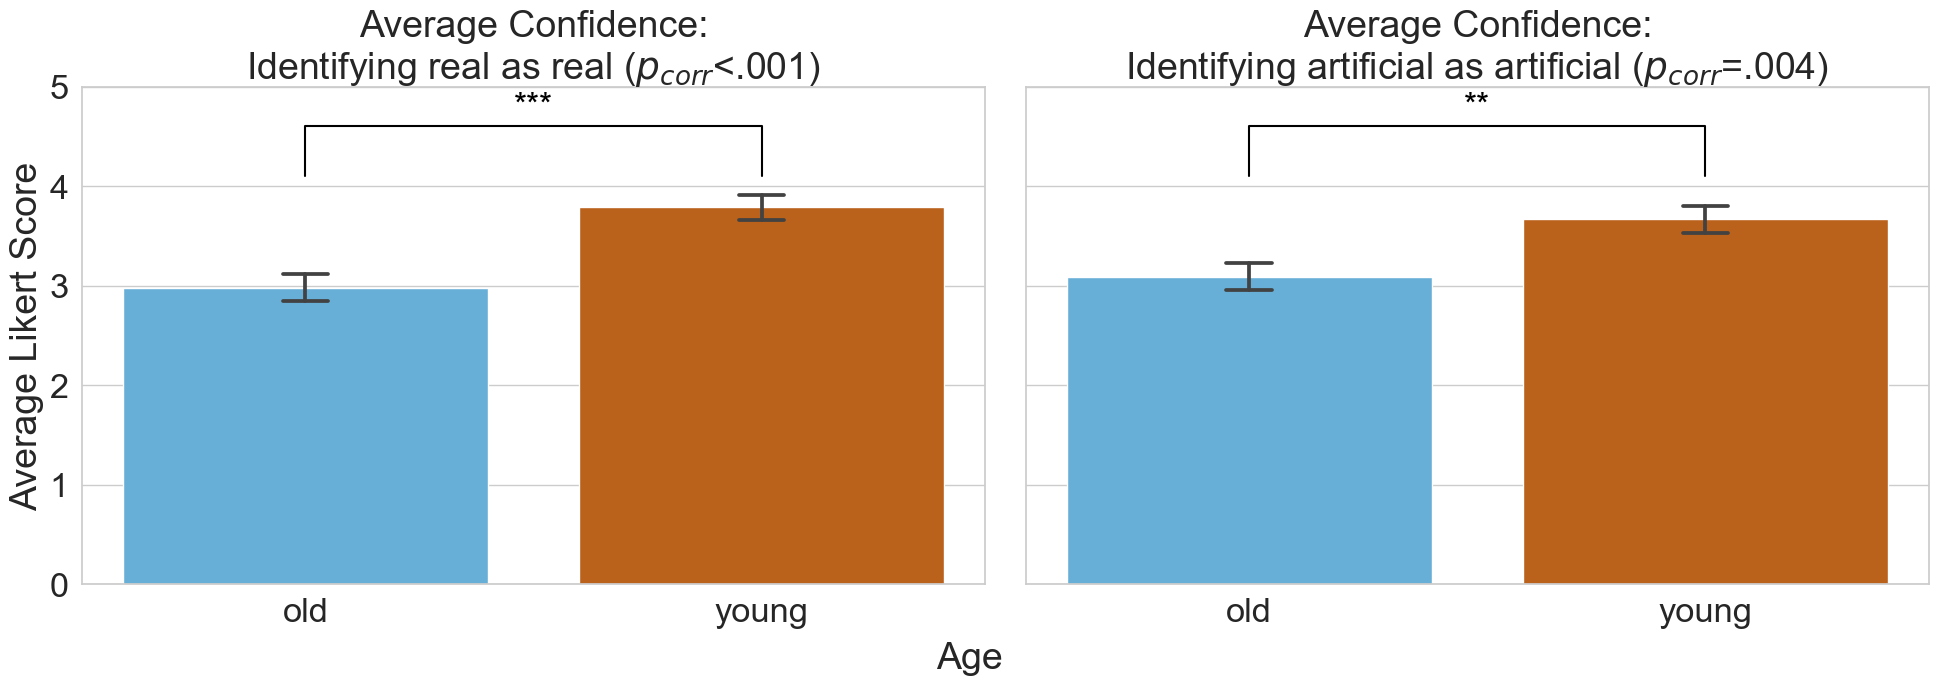

In [27]:
#### Generate plot showing mean Likert estimates for confidence (Figure 6 in CHIRA24 paper)
# likert coding: 1 = very uncertain; 5 = very certain; 3 = neutral

# Create the figure and axes for three side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True,sharey=True)
fig.text(0.5, 0.00, 'Age', ha='center')

# Main effects plot for 'Age_Group'
sns.barplot(
    data=df_cleaned, 
    x='Age_Group', 
    y='ConEcht_Int', 
    #ci='sem',  # Use standard error of the mean
    errorbar='se',
    palette=age_palette,  # Apply colorblind palette to age groups
    capsize=.1,
    ax=axes[0]
)

axes[0].set_title('Average Confidence:\nIdentifying real as real ($p_{corr}$<.001)')
axes[0].set_xlabel('')
axes[0].set_ylabel('Average Likert Score')
axes[0].set_ylim(0, 5)  # Keep y-axis consistent across plots

# Add significance annotation with bracket
x1, x2 = 0, 1  # x-coordinates of the bars
y, h, col = 4.1, 0.5, 'black'  # y: height, h: height of the bracket, col: color
axes[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)
axes[0].annotate('***', xy=((x1+x2)*.5, y+h), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', color=col, fontsize=24)

sns.barplot(
    data=df_cleaned, 
    x='Age_Group', 
    y='ConFake_Int', 
    #ci='sem',  # Use standard error of the mean
    errorbar='se',
    palette=age_palette,  # Apply colorblind palette to age groups
    capsize=.1,
    ax=axes[1]
)

axes[1].set_title('Average Confidence:\nIdentifying artificial as artificial ($p_{corr}$=.004)')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 5)  # Keep y-axis consistent across plots

# Add significance annotation with bracket
x1, x2 = 0, 1  # x-coordinates of the bars
y, h, col = 4.1, 0.5, 'black'  # y: height, h: height of the bracket, col: color
axes[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color=col)
axes[1].annotate('**', xy=((x1+x2)*.5, y+h), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', color=col, fontsize=24)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig('H4_Confidence.pdf', dpi=300, bbox_inches='tight')
plt.savefig('H4_Confidence.svg', dpi=300, bbox_inches='tight')

plt.show()

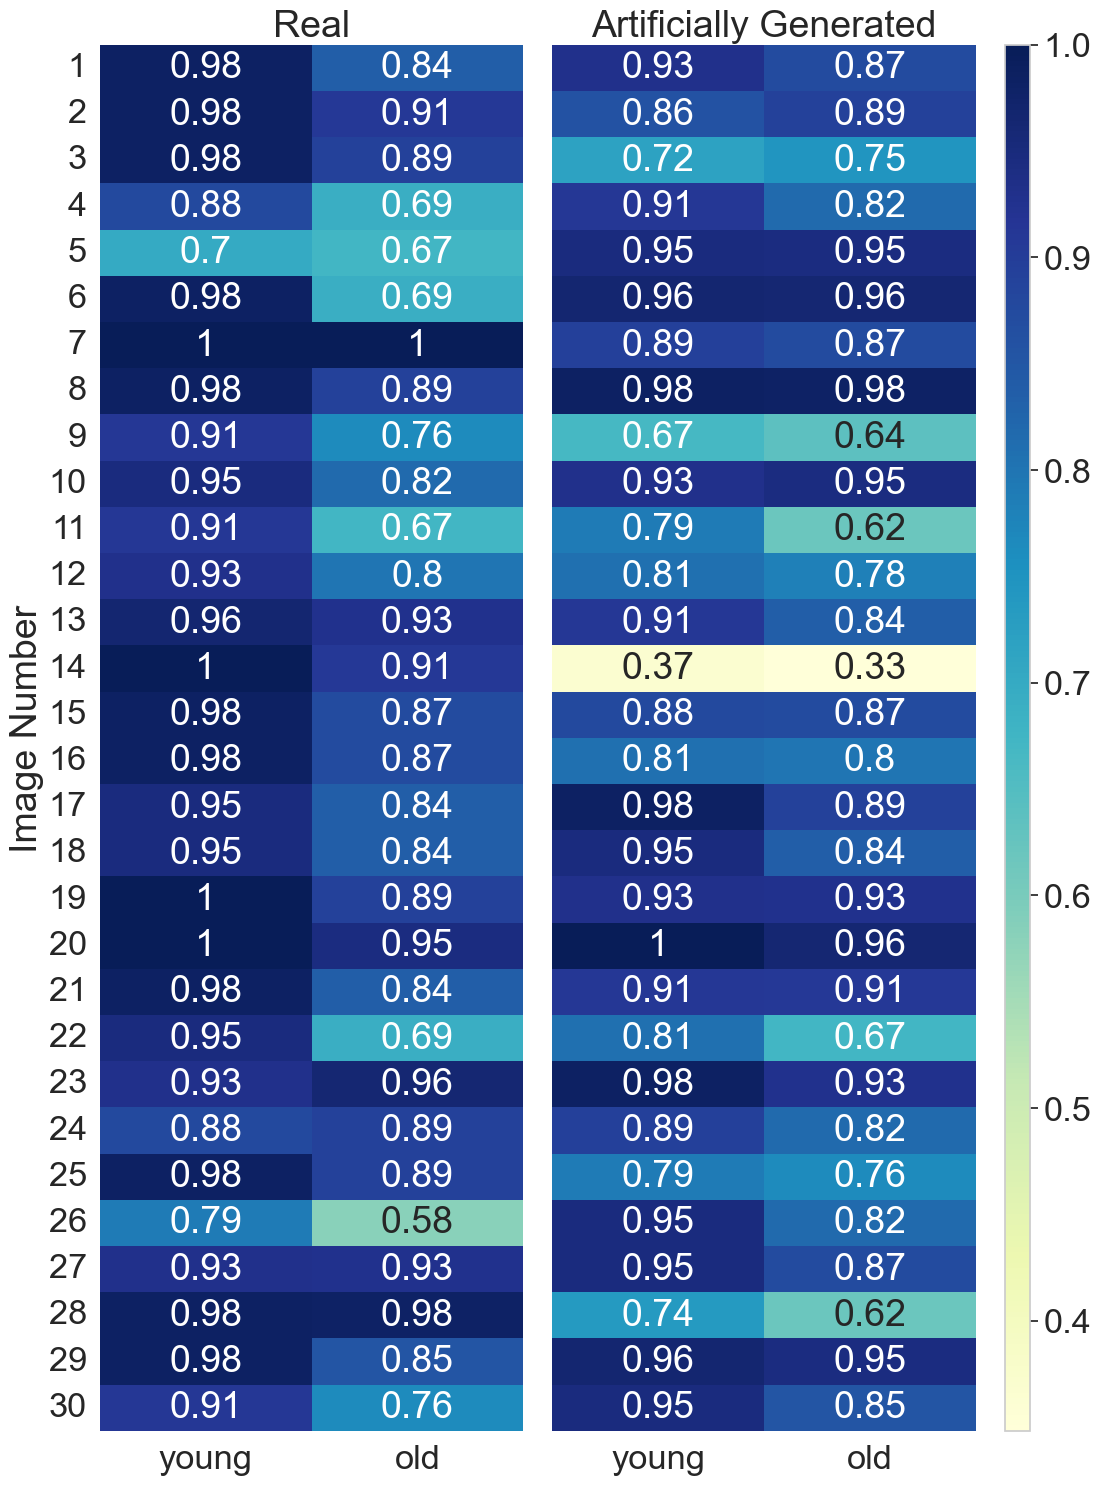

In [28]:
#@title Heatmap of accuracies for all images (basis for Figure 5 in CHIRA24 paper)

from matplotlib.gridspec import GridSpec

real_columns = [col for col in df_cleaned.columns if col.startswith('Echt') and col.endswith('_correct')]
fake_columns = [col for col in df_cleaned.columns if col.startswith('Fake') and col.endswith('_correct')]

df_cleaned_old=df_cleaned[df_cleaned['Age_Group'] == 'old']
df_cleaned_young=df_cleaned[df_cleaned['Age_Group'] == 'young']

accuracy_data = df_cleaned[real_columns + fake_columns].mean().values.reshape(2, -1)
accuracy_data_old = df_cleaned_old[real_columns + fake_columns].mean().values.reshape(2, -1)
accuracy_data_young = df_cleaned_young[real_columns + fake_columns].mean().values.reshape(2, -1)

# Transpose the data to rotate the heatmap
real_data_old_rotated = accuracy_data_old[:1].T  # Data for real images (old group)
real_data_young_rotated = accuracy_data_young[:1].T  # Data for real images (young group)
AIgen_data_old_rotated = accuracy_data_old[1:].T  # Data for artificially generated images (old group)
AIgen_data_young_rotated = accuracy_data_young[1:].T  # Data for artificially generated images (young group)

# Combine data from real_data_old_rotated and real_data_young_rotated
combined_real_data = np.hstack([real_data_young_rotated,real_data_old_rotated])
combined_AIgen_data = np.hstack([AIgen_data_young_rotated,AIgen_data_old_rotated])

# Create a figure with GridSpec for precise control over layout
fig = plt.figure(figsize=(12, 18))
gs = GridSpec(1, 3, width_ratios=[50, 50, 3], wspace=0.1)  # 1 row, 3 columns

# First row: Heatmaps for real images
ax0 = fig.add_subplot(gs[0, 0])
sns.heatmap(combined_real_data, annot=True, cmap='YlGnBu', 
            yticklabels=range(1, combined_real_data.shape[0] + 1), 
            xticklabels=['young','old'], 
            ax=ax0,
            cbar=False,
            vmin=np.min(accuracy_data),
            vmax=1)
ax0.set_title('Real')
ax0.set_yticklabels(ax0.get_yticklabels(), rotation=0)  # Rotate yticklabels

# Second heatmap for the 'young' age group (rotated) with colorbar
ax1 = fig.add_subplot(gs[0, 1])
sns.heatmap(combined_AIgen_data, annot=True, cmap='YlGnBu', 
            yticklabels=[], 
            xticklabels=['young','old'], 
            ax=ax1,
            cbar=False,
            vmin=np.min(accuracy_data),
            vmax=1)
ax1.set_title('Artificially Generated')

# Colorbar for the rightmost plot, placed in the third column of GridSpec
cbar_ax = fig.add_subplot(gs[:, 2])  # This occupies both rows in the third column
cbar = plt.colorbar(ax1.collections[0], cax=cbar_ax)

# Set the shared y-axis label
fig.text(0.05, 0.5, 'Image Number', va='center', rotation='vertical')

plt.savefig('Heatmaps_accuracy_perImageType.svg', dpi=300, bbox_inches='tight')
plt.savefig('Heatmaps_accuracy_perImageType.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()